In [1]:
# Load the huggingface sst2 dataset
from datasets import load_dataset

dataset = load_dataset("sst2")


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})
{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


In [3]:
num_labels = len(set(dataset["train"]["label"]))
print(num_labels)

2


In [4]:
# Delete original test set, split the train set into train and validation, and assign original validation set to test set

dataset["test"] = dataset["validation"]

train_size = int(len(dataset["train"]) * 0.98)
train_set = dataset["train"].select(list(range(train_size)))
validation_set = dataset["train"].select(list(range(train_size, len(dataset["train"]))))
dataset["train"] = train_set
dataset["validation"] = validation_set

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 66002
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1347
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
})


In [5]:
from transformers import AutoTokenizer, RobertaModel, RobertaForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# model = RobertaModel.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Get the LoRA model
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=['query', 'key', 'value'],
    task_type=TaskType.SEQ_CLS
)

lora_model = get_peft_model(model, lora_config)

total_params = sum(param.numel() for param in lora_model.parameters())
trainable_params = sum(param.numel() for param in lora_model.parameters() if param.requires_grad)
print(f"Total params: {total_params}")
print(f"Trainable params: {trainable_params}")
print(f"Percentage trainable: {trainable_params / total_params * 100:.2f}%")

Total params: 125681668
Trainable params: 1034498
Percentage trainable: 0.82%


In [7]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Print the first example of the training set
print(tokenized_dataset["train"][0])



{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'input_ids': [0, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [8]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric
import numpy as np
import logging

# Hyperparameters
step_size = 500
lr = 1e-4
num_epochs = 3

# Eval metric for accuracy
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    result = metric.compute(predictions=predictions, references=labels)

    return result


# Custom trainer for logging training accuracy
class TrainerWithTrainingAccuracy(Trainer):
    training_accuracies = []
    # curr_step = 0

    def training_step(self, model, inputs):
        # Perform a regular training step
        loss = super().training_step(model, inputs)
        
        # Compute training accuracy after every training step
        self.log_training_accuracy(inputs)
        return loss

    def log_training_accuracy(self, inputs):
        model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            labels = inputs["labels"]
            predictions = np.argmax(logits.cpu().numpy(), axis=-1)
            labels = labels.cpu().numpy()
            accuracy = metric.compute(predictions=predictions, references=labels)
            self.training_accuracies.append(accuracy["accuracy"])
            # self.log({"train_accuracy": accuracy["accuracy"]})
        if len(self.training_accuracies) % step_size == 0:
            self.log({"train_accuracy": sum(self.training_accuracies) / len(self.training_accuracies)})
            self.training_accuracies = []
        model.train()


training_args = TrainingArguments(
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=num_epochs,
    logging_dir='./lora_logs',
    logging_steps=step_size,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=step_size,
    output_dir='./lora_results',
    overwrite_output_dir=True,
    save_steps=step_size,
    save_total_limit=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=lr,
    # warmup_steps=500,
)

trainer = TrainerWithTrainingAccuracy(
    model=lora_model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()




C:\Users\Shaobo Liang\AppData\Local\Temp\ipykernel_53064\3496727498.py:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` 

{'train_accuracy': 0.7725, 'epoch': 0.03}
{'loss': 0.5877, 'learning_rate': 9.898996020443206e-05, 'epoch': 0.03}


                                                     
  1%|          | 500/49503 [02:52<4:00:27,  3.40it/s]

{'eval_loss': 0.5172083973884583, 'eval_accuracy': 0.888641425389755, 'eval_runtime': 27.8823, 'eval_samples_per_second': 48.31, 'eval_steps_per_second': 12.087, 'epoch': 0.03}


  2%|▏         | 1000/49503 [05:15<4:02:54,  3.33it/s] 

{'train_accuracy': 0.894, 'epoch': 0.06}
{'loss': 0.4955, 'learning_rate': 9.79799204088641e-05, 'epoch': 0.06}


                                                      
  2%|▏         | 1000/49503 [05:43<4:02:54,  3.33it/s]

{'eval_loss': 0.4080137312412262, 'eval_accuracy': 0.8864142538975501, 'eval_runtime': 27.4748, 'eval_samples_per_second': 49.027, 'eval_steps_per_second': 12.266, 'epoch': 0.06}


  3%|▎         | 1500/49503 [08:03<3:48:33,  3.50it/s]  

{'train_accuracy': 0.896, 'epoch': 0.09}
{'loss': 0.4519, 'learning_rate': 9.696988061329618e-05, 'epoch': 0.09}


                                                      
  3%|▎         | 1500/49503 [08:30<3:48:33,  3.50it/s]

{'eval_loss': 0.41508179903030396, 'eval_accuracy': 0.8901262063845583, 'eval_runtime': 27.3253, 'eval_samples_per_second': 49.295, 'eval_steps_per_second': 12.333, 'epoch': 0.09}


  4%|▍         | 2000/49503 [10:50<3:44:15,  3.53it/s]  

{'train_accuracy': 0.905, 'epoch': 0.12}
{'loss': 0.3994, 'learning_rate': 9.595984081772822e-05, 'epoch': 0.12}


                                                      
  4%|▍         | 2000/49503 [11:17<3:44:15,  3.53it/s]

{'eval_loss': 0.36201298236846924, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 27.2566, 'eval_samples_per_second': 49.419, 'eval_steps_per_second': 12.364, 'epoch': 0.12}


  5%|▌         | 2500/49503 [13:38<3:44:29,  3.49it/s]  

{'train_accuracy': 0.909, 'epoch': 0.15}
{'loss': 0.4037, 'learning_rate': 9.494980102216028e-05, 'epoch': 0.15}


                                                      
  5%|▌         | 2500/49503 [14:06<3:44:29,  3.49it/s]

{'eval_loss': 0.4619287848472595, 'eval_accuracy': 0.8997772828507795, 'eval_runtime': 27.235, 'eval_samples_per_second': 49.458, 'eval_steps_per_second': 12.374, 'epoch': 0.15}


  6%|▌         | 3000/49503 [16:26<3:40:47,  3.51it/s]  

{'train_accuracy': 0.9075, 'epoch': 0.18}
{'loss': 0.4057, 'learning_rate': 9.393976122659234e-05, 'epoch': 0.18}


                                                      
  6%|▌         | 3000/49503 [16:53<3:40:47,  3.51it/s]

{'eval_loss': 0.35725080966949463, 'eval_accuracy': 0.9049740163325909, 'eval_runtime': 27.256, 'eval_samples_per_second': 49.42, 'eval_steps_per_second': 12.364, 'epoch': 0.18}


  7%|▋         | 3500/49503 [19:14<3:33:41,  3.59it/s]  

{'train_accuracy': 0.904, 'epoch': 0.21}
{'loss': 0.3961, 'learning_rate': 9.292972143102438e-05, 'epoch': 0.21}


                                                      
  7%|▋         | 3500/49503 [19:40<3:33:41,  3.59it/s]

{'eval_loss': 0.5052911639213562, 'eval_accuracy': 0.8982925018559762, 'eval_runtime': 26.5861, 'eval_samples_per_second': 50.666, 'eval_steps_per_second': 12.676, 'epoch': 0.21}


  8%|▊         | 4000/49503 [22:01<3:30:10,  3.61it/s]  

{'train_accuracy': 0.9075, 'epoch': 0.24}
{'loss': 0.4161, 'learning_rate': 9.191968163545645e-05, 'epoch': 0.24}


                                                      
  8%|▊         | 4000/49503 [22:28<3:30:10,  3.61it/s]

{'eval_loss': 0.2765389680862427, 'eval_accuracy': 0.9057164068299925, 'eval_runtime': 27.0286, 'eval_samples_per_second': 49.836, 'eval_steps_per_second': 12.468, 'epoch': 0.24}


  9%|▉         | 4500/49503 [24:50<3:31:40,  3.54it/s]  

{'train_accuracy': 0.9135, 'epoch': 0.27}
{'loss': 0.3653, 'learning_rate': 9.09096418398885e-05, 'epoch': 0.27}


                                                      
  9%|▉         | 4500/49503 [25:17<3:31:40,  3.54it/s]

{'eval_loss': 0.366177499294281, 'eval_accuracy': 0.9072011878247959, 'eval_runtime': 27.1192, 'eval_samples_per_second': 49.67, 'eval_steps_per_second': 12.427, 'epoch': 0.27}


 10%|█         | 5000/49503 [27:37<3:27:12,  3.58it/s]  

{'train_accuracy': 0.9115, 'epoch': 0.3}
{'loss': 0.3601, 'learning_rate': 8.989960204432055e-05, 'epoch': 0.3}


                                                      
 10%|█         | 5000/49503 [28:05<3:27:12,  3.58it/s]

{'eval_loss': 0.3469252288341522, 'eval_accuracy': 0.9131403118040089, 'eval_runtime': 27.2295, 'eval_samples_per_second': 49.468, 'eval_steps_per_second': 12.376, 'epoch': 0.3}


 11%|█         | 5500/49503 [30:25<3:32:40,  3.45it/s]  

{'train_accuracy': 0.91, 'epoch': 0.33}
{'loss': 0.3684, 'learning_rate': 8.88895622487526e-05, 'epoch': 0.33}


                                                      
 11%|█         | 5500/49503 [30:52<3:32:40,  3.45it/s]

{'eval_loss': 0.31158754229545593, 'eval_accuracy': 0.9153674832962138, 'eval_runtime': 27.2755, 'eval_samples_per_second': 49.385, 'eval_steps_per_second': 12.355, 'epoch': 0.33}


 12%|█▏        | 6000/49503 [33:12<3:32:09,  3.42it/s]  

{'train_accuracy': 0.9255, 'epoch': 0.36}
{'loss': 0.3408, 'learning_rate': 8.787952245318465e-05, 'epoch': 0.36}


                                                      
 12%|█▏        | 6000/49503 [33:39<3:32:09,  3.42it/s]

{'eval_loss': 0.40368497371673584, 'eval_accuracy': 0.9049740163325909, 'eval_runtime': 27.1371, 'eval_samples_per_second': 49.637, 'eval_steps_per_second': 12.418, 'epoch': 0.36}


 13%|█▎        | 6500/49503 [35:59<3:22:06,  3.55it/s]  

{'train_accuracy': 0.915, 'epoch': 0.39}
{'loss': 0.3858, 'learning_rate': 8.686948265761673e-05, 'epoch': 0.39}


                                                      
 13%|█▎        | 6500/49503 [36:26<3:22:06,  3.55it/s]

{'eval_loss': 0.3679314851760864, 'eval_accuracy': 0.9086859688195991, 'eval_runtime': 27.0672, 'eval_samples_per_second': 49.765, 'eval_steps_per_second': 12.451, 'epoch': 0.39}


 14%|█▍        | 7000/49503 [38:46<3:27:31,  3.41it/s]  

{'train_accuracy': 0.913, 'epoch': 0.42}
{'loss': 0.3731, 'learning_rate': 8.585944286204877e-05, 'epoch': 0.42}


                                                      
 14%|█▍        | 7000/49503 [39:13<3:27:31,  3.41it/s]

{'eval_loss': 0.35944581031799316, 'eval_accuracy': 0.9086859688195991, 'eval_runtime': 26.6641, 'eval_samples_per_second': 50.517, 'eval_steps_per_second': 12.639, 'epoch': 0.42}


 15%|█▌        | 7500/49503 [41:33<3:20:16,  3.50it/s] 

{'train_accuracy': 0.9215, 'epoch': 0.45}
{'loss': 0.3441, 'learning_rate': 8.484940306648083e-05, 'epoch': 0.45}


                                                      
 15%|█▌        | 7500/49503 [42:00<3:20:16,  3.50it/s]

{'eval_loss': 0.3708410859107971, 'eval_accuracy': 0.9146250927988122, 'eval_runtime': 27.1955, 'eval_samples_per_second': 49.53, 'eval_steps_per_second': 12.392, 'epoch': 0.45}


 16%|█▌        | 8000/49503 [44:27<3:15:52,  3.53it/s] 

{'train_accuracy': 0.921, 'epoch': 0.48}
{'loss': 0.3368, 'learning_rate': 8.383936327091287e-05, 'epoch': 0.48}


                                                      
 16%|█▌        | 8000/49503 [44:55<3:15:52,  3.53it/s]

{'eval_loss': 0.3109091520309448, 'eval_accuracy': 0.9175946547884187, 'eval_runtime': 27.9131, 'eval_samples_per_second': 48.257, 'eval_steps_per_second': 12.073, 'epoch': 0.48}


 17%|█▋        | 8500/49503 [47:18<3:19:29,  3.43it/s]  

{'train_accuracy': 0.9285, 'epoch': 0.52}
{'loss': 0.3378, 'learning_rate': 8.282932347534493e-05, 'epoch': 0.52}


                                                      
 17%|█▋        | 8500/49503 [47:46<3:19:29,  3.43it/s]

{'eval_loss': 0.3354998230934143, 'eval_accuracy': 0.9094283593170007, 'eval_runtime': 27.8737, 'eval_samples_per_second': 48.325, 'eval_steps_per_second': 12.09, 'epoch': 0.52}


 18%|█▊        | 9000/49503 [50:07<3:06:40,  3.62it/s] 

{'train_accuracy': 0.921, 'epoch': 0.55}
{'loss': 0.341, 'learning_rate': 8.181928367977699e-05, 'epoch': 0.55}


                                                      
 18%|█▊        | 9000/49503 [50:34<3:06:40,  3.62it/s]

{'eval_loss': 0.31185635924339294, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 27.094, 'eval_samples_per_second': 49.716, 'eval_steps_per_second': 12.438, 'epoch': 0.55}


 19%|█▉        | 9500/49503 [52:54<3:11:27,  3.48it/s] 

{'train_accuracy': 0.9155, 'epoch': 0.58}
{'loss': 0.3548, 'learning_rate': 8.080924388420904e-05, 'epoch': 0.58}


                                                      
 19%|█▉        | 9500/49503 [53:21<3:11:27,  3.48it/s]

{'eval_loss': 0.3217617869377136, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 27.1646, 'eval_samples_per_second': 49.587, 'eval_steps_per_second': 12.406, 'epoch': 0.58}


 20%|██        | 10000/49503 [55:41<2:57:43,  3.70it/s]

{'train_accuracy': 0.9155, 'epoch': 0.61}
{'loss': 0.3725, 'learning_rate': 7.97992040886411e-05, 'epoch': 0.61}


                                                       
 20%|██        | 10000/49503 [56:08<2:57:43,  3.70it/s]

{'eval_loss': 0.26786068081855774, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 27.2345, 'eval_samples_per_second': 49.459, 'eval_steps_per_second': 12.374, 'epoch': 0.61}


 21%|██        | 10500/49503 [58:28<3:02:02,  3.57it/s] 

{'train_accuracy': 0.9255, 'epoch': 0.64}
{'loss': 0.3258, 'learning_rate': 7.878916429307314e-05, 'epoch': 0.64}


                                                       
 21%|██        | 10500/49503 [58:55<3:02:02,  3.57it/s]

{'eval_loss': 0.31883013248443604, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 26.4924, 'eval_samples_per_second': 50.845, 'eval_steps_per_second': 12.721, 'epoch': 0.64}


 22%|██▏       | 11000/49503 [1:01:15<2:59:24,  3.58it/s]

{'train_accuracy': 0.9295, 'epoch': 0.67}
{'loss': 0.3198, 'learning_rate': 7.77791244975052e-05, 'epoch': 0.67}


                                                         
 22%|██▏       | 11000/49503 [1:01:42<2:59:24,  3.58it/s]

{'eval_loss': 0.3245168626308441, 'eval_accuracy': 0.9175946547884187, 'eval_runtime': 26.9958, 'eval_samples_per_second': 49.897, 'eval_steps_per_second': 12.483, 'epoch': 0.67}


 23%|██▎       | 11500/49503 [1:04:01<2:59:45,  3.52it/s] 

{'train_accuracy': 0.9245, 'epoch': 0.7}
{'loss': 0.3484, 'learning_rate': 7.676908470193726e-05, 'epoch': 0.7}


                                                         
 23%|██▎       | 11500/49503 [1:04:29<2:59:45,  3.52it/s]

{'eval_loss': 0.32624003291130066, 'eval_accuracy': 0.9205642167780252, 'eval_runtime': 27.2617, 'eval_samples_per_second': 49.41, 'eval_steps_per_second': 12.362, 'epoch': 0.7}


 24%|██▍       | 12000/49503 [1:06:48<2:56:58,  3.53it/s] 

{'train_accuracy': 0.9275, 'epoch': 0.73}
{'loss': 0.3316, 'learning_rate': 7.575904490636932e-05, 'epoch': 0.73}


                                                         
 24%|██▍       | 12000/49503 [1:07:15<2:56:58,  3.53it/s]

{'eval_loss': 0.3088471293449402, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 27.3898, 'eval_samples_per_second': 49.179, 'eval_steps_per_second': 12.304, 'epoch': 0.73}


 25%|██▌       | 12500/49503 [1:09:35<2:54:58,  3.52it/s] 

{'train_accuracy': 0.922, 'epoch': 0.76}
{'loss': 0.3204, 'learning_rate': 7.474900511080138e-05, 'epoch': 0.76}


                                                         
 25%|██▌       | 12500/49503 [1:10:02<2:54:58,  3.52it/s]

{'eval_loss': 0.4499388337135315, 'eval_accuracy': 0.9101707498144024, 'eval_runtime': 27.0594, 'eval_samples_per_second': 49.779, 'eval_steps_per_second': 12.454, 'epoch': 0.76}


 26%|██▋       | 13000/49503 [1:12:22<2:50:46,  3.56it/s] 

{'train_accuracy': 0.932, 'epoch': 0.79}
{'loss': 0.3232, 'learning_rate': 7.373896531523342e-05, 'epoch': 0.79}


                                                         
 26%|██▋       | 13000/49503 [1:12:49<2:50:46,  3.56it/s]

{'eval_loss': 0.3131043612957001, 'eval_accuracy': 0.9168522642910171, 'eval_runtime': 27.1223, 'eval_samples_per_second': 49.664, 'eval_steps_per_second': 12.425, 'epoch': 0.79}


 27%|██▋       | 13500/49503 [1:15:08<2:48:06,  3.57it/s] 

{'train_accuracy': 0.924, 'epoch': 0.82}
{'loss': 0.3166, 'learning_rate': 7.272892551966548e-05, 'epoch': 0.82}


                                                         
 27%|██▋       | 13500/49503 [1:15:35<2:48:06,  3.57it/s]

{'eval_loss': 0.39693576097488403, 'eval_accuracy': 0.9183370452858204, 'eval_runtime': 27.1154, 'eval_samples_per_second': 49.677, 'eval_steps_per_second': 12.428, 'epoch': 0.82}


 28%|██▊       | 14000/49503 [1:17:55<2:43:59,  3.61it/s] 

{'train_accuracy': 0.9225, 'epoch': 0.85}
{'loss': 0.3455, 'learning_rate': 7.171888572409753e-05, 'epoch': 0.85}


                                                         
 28%|██▊       | 14000/49503 [1:18:22<2:43:59,  3.61it/s]

{'eval_loss': 0.30977863073349, 'eval_accuracy': 0.9190794357832219, 'eval_runtime': 26.5821, 'eval_samples_per_second': 50.673, 'eval_steps_per_second': 12.678, 'epoch': 0.85}


 29%|██▉       | 14500/49503 [1:20:42<2:45:18,  3.53it/s] 

{'train_accuracy': 0.923, 'epoch': 0.88}
{'loss': 0.3355, 'learning_rate': 7.070884592852959e-05, 'epoch': 0.88}


                                                         
 29%|██▉       | 14500/49503 [1:21:09<2:45:18,  3.53it/s]

{'eval_loss': 0.35527101159095764, 'eval_accuracy': 0.9198218262806236, 'eval_runtime': 27.1747, 'eval_samples_per_second': 49.568, 'eval_steps_per_second': 12.401, 'epoch': 0.88}


 30%|███       | 15000/49503 [1:23:04<1:46:05,  5.42it/s] 

{'train_accuracy': 0.9295, 'epoch': 0.91}
{'loss': 0.3469, 'learning_rate': 6.969880613296165e-05, 'epoch': 0.91}


                                                         
 30%|███       | 15000/49503 [1:23:21<1:46:05,  5.42it/s]

{'eval_loss': 0.32461273670196533, 'eval_accuracy': 0.9146250927988122, 'eval_runtime': 17.3449, 'eval_samples_per_second': 77.66, 'eval_steps_per_second': 19.429, 'epoch': 0.91}


 31%|███▏      | 15500/49503 [1:24:48<1:53:15,  5.00it/s] 

{'train_accuracy': 0.925, 'epoch': 0.94}
{'loss': 0.3347, 'learning_rate': 6.868876633739369e-05, 'epoch': 0.94}


                                                         
 31%|███▏      | 15500/49503 [1:25:06<1:53:15,  5.00it/s]

{'eval_loss': 0.32683536410331726, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 17.3861, 'eval_samples_per_second': 77.476, 'eval_steps_per_second': 19.383, 'epoch': 0.94}


 32%|███▏      | 16000/49503 [1:26:34<1:51:55,  4.99it/s] 

{'train_accuracy': 0.9295, 'epoch': 0.97}
{'loss': 0.3395, 'learning_rate': 6.767872654182575e-05, 'epoch': 0.97}


                                                         
 32%|███▏      | 16000/49503 [1:26:52<1:51:55,  4.99it/s]

{'eval_loss': 0.3651677370071411, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 17.3727, 'eval_samples_per_second': 77.535, 'eval_steps_per_second': 19.398, 'epoch': 0.97}


 33%|███▎      | 16500/49503 [1:28:19<1:31:38,  6.00it/s] 

{'train_accuracy': 0.92, 'epoch': 1.0}
{'loss': 0.3162, 'learning_rate': 6.666868674625781e-05, 'epoch': 1.0}


                                                         
 33%|███▎      | 16500/49503 [1:28:37<1:31:38,  6.00it/s]

{'eval_loss': 0.3207046389579773, 'eval_accuracy': 0.9146250927988122, 'eval_runtime': 17.4295, 'eval_samples_per_second': 77.283, 'eval_steps_per_second': 19.335, 'epoch': 1.0}


 34%|███▍      | 17000/49503 [1:30:05<1:33:33,  5.79it/s] 

{'train_accuracy': 0.9385, 'epoch': 1.03}
{'loss': 0.3047, 'learning_rate': 6.565864695068987e-05, 'epoch': 1.03}


                                                         
 34%|███▍      | 17000/49503 [1:30:22<1:33:33,  5.79it/s]

{'eval_loss': 0.3207911252975464, 'eval_accuracy': 0.9190794357832219, 'eval_runtime': 17.3604, 'eval_samples_per_second': 77.59, 'eval_steps_per_second': 19.412, 'epoch': 1.03}


 35%|███▌      | 17500/49503 [1:31:52<1:35:50,  5.57it/s] 

{'train_accuracy': 0.945, 'epoch': 1.06}
{'loss': 0.2538, 'learning_rate': 6.464860715512191e-05, 'epoch': 1.06}


                                                         
 35%|███▌      | 17500/49503 [1:32:08<1:35:50,  5.57it/s]

{'eval_loss': 0.3573460578918457, 'eval_accuracy': 0.9227913882702301, 'eval_runtime': 16.0635, 'eval_samples_per_second': 83.855, 'eval_steps_per_second': 20.979, 'epoch': 1.06}


 36%|███▋      | 18000/49503 [1:33:38<1:34:54,  5.53it/s] 

{'train_accuracy': 0.9385, 'epoch': 1.09}
{'loss': 0.3246, 'learning_rate': 6.363856735955397e-05, 'epoch': 1.09}


                                                         
 36%|███▋      | 18000/49503 [1:33:56<1:34:54,  5.53it/s]

{'eval_loss': 0.34096935391426086, 'eval_accuracy': 0.9198218262806236, 'eval_runtime': 17.7256, 'eval_samples_per_second': 75.992, 'eval_steps_per_second': 19.012, 'epoch': 1.09}


 37%|███▋      | 18500/49503 [1:35:24<1:39:26,  5.20it/s] 

{'train_accuracy': 0.938, 'epoch': 1.12}
{'loss': 0.3061, 'learning_rate': 6.262852756398602e-05, 'epoch': 1.12}


                                                         
 37%|███▋      | 18500/49503 [1:35:42<1:39:26,  5.20it/s]

{'eval_loss': 0.3237834870815277, 'eval_accuracy': 0.9198218262806236, 'eval_runtime': 17.368, 'eval_samples_per_second': 77.557, 'eval_steps_per_second': 19.404, 'epoch': 1.12}


 38%|███▊      | 19000/49503 [1:37:10<1:39:20,  5.12it/s] 

{'train_accuracy': 0.945, 'epoch': 1.15}
{'loss': 0.2854, 'learning_rate': 6.161848776841808e-05, 'epoch': 1.15}


                                                         
 38%|███▊      | 19000/49503 [1:37:33<1:39:20,  5.12it/s]

{'eval_loss': 0.32435107231140137, 'eval_accuracy': 0.9235337787676318, 'eval_runtime': 22.6685, 'eval_samples_per_second': 59.422, 'eval_steps_per_second': 14.866, 'epoch': 1.15}


 39%|███▉      | 19500/49503 [1:39:06<1:25:27,  5.85it/s] 

{'train_accuracy': 0.9375, 'epoch': 1.18}
{'loss': 0.3188, 'learning_rate': 6.060844797285013e-05, 'epoch': 1.18}


                                                         
 39%|███▉      | 19500/49503 [1:39:24<1:25:27,  5.85it/s]

{'eval_loss': 0.32570675015449524, 'eval_accuracy': 0.9242761692650334, 'eval_runtime': 17.7984, 'eval_samples_per_second': 75.681, 'eval_steps_per_second': 18.934, 'epoch': 1.18}


 40%|████      | 20000/49503 [1:40:55<1:33:27,  5.26it/s] 

{'train_accuracy': 0.9375, 'epoch': 1.21}
{'loss': 0.3074, 'learning_rate': 5.9598408177282184e-05, 'epoch': 1.21}


                                                         
 40%|████      | 20000/49503 [1:41:13<1:33:27,  5.26it/s]

{'eval_loss': 0.31769323348999023, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 17.7761, 'eval_samples_per_second': 75.776, 'eval_steps_per_second': 18.958, 'epoch': 1.21}


 41%|████▏     | 20500/49503 [1:42:42<1:35:15,  5.07it/s] 

{'train_accuracy': 0.9385, 'epoch': 1.24}
{'loss': 0.2985, 'learning_rate': 5.858836838171424e-05, 'epoch': 1.24}


                                                         
 41%|████▏     | 20500/49503 [1:43:00<1:35:15,  5.07it/s]

{'eval_loss': 0.28472810983657837, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 17.736, 'eval_samples_per_second': 75.947, 'eval_steps_per_second': 19.001, 'epoch': 1.24}


 42%|████▏     | 21000/49503 [1:44:30<1:27:18,  5.44it/s] 

{'train_accuracy': 0.9355, 'epoch': 1.27}
{'loss': 0.3122, 'learning_rate': 5.75783285861463e-05, 'epoch': 1.27}


                                                         
 42%|████▏     | 21000/49503 [1:44:48<1:27:18,  5.44it/s]

{'eval_loss': 0.3386017084121704, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 17.7174, 'eval_samples_per_second': 76.027, 'eval_steps_per_second': 19.021, 'epoch': 1.27}


 43%|████▎     | 21500/49503 [1:46:20<1:23:51,  5.57it/s] 

{'train_accuracy': 0.942, 'epoch': 1.3}
{'loss': 0.3003, 'learning_rate': 5.656828879057835e-05, 'epoch': 1.3}


                                                         
 43%|████▎     | 21500/49503 [1:46:36<1:23:51,  5.57it/s]

{'eval_loss': 0.3794029951095581, 'eval_accuracy': 0.9183370452858204, 'eval_runtime': 16.457, 'eval_samples_per_second': 81.849, 'eval_steps_per_second': 20.478, 'epoch': 1.3}


 44%|████▍     | 22000/49503 [1:48:08<1:23:36,  5.48it/s] 

{'train_accuracy': 0.94, 'epoch': 1.33}
{'loss': 0.2908, 'learning_rate': 5.555824899501041e-05, 'epoch': 1.33}


                                                         
 44%|████▍     | 22000/49503 [1:48:26<1:23:36,  5.48it/s]

{'eval_loss': 0.35073360800743103, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 18.1549, 'eval_samples_per_second': 74.195, 'eval_steps_per_second': 18.562, 'epoch': 1.33}


 45%|████▌     | 22500/49503 [1:49:56<1:28:14,  5.10it/s] 

{'train_accuracy': 0.945, 'epoch': 1.36}
{'loss': 0.2563, 'learning_rate': 5.454820919944246e-05, 'epoch': 1.36}


                                                         
 45%|████▌     | 22500/49503 [1:50:14<1:28:14,  5.10it/s]

{'eval_loss': 0.3359050452709198, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 17.6859, 'eval_samples_per_second': 76.162, 'eval_steps_per_second': 19.055, 'epoch': 1.36}


 46%|████▋     | 23000/49503 [1:51:43<1:17:47,  5.68it/s] 

{'train_accuracy': 0.942, 'epoch': 1.39}
{'loss': 0.2683, 'learning_rate': 5.3538169403874515e-05, 'epoch': 1.39}


                                                         
 46%|████▋     | 23000/49503 [1:52:01<1:17:47,  5.68it/s]

{'eval_loss': 0.3310449421405792, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 17.7512, 'eval_samples_per_second': 75.882, 'eval_steps_per_second': 18.985, 'epoch': 1.39}


 47%|████▋     | 23500/49503 [1:53:31<1:19:05,  5.48it/s] 

{'train_accuracy': 0.944, 'epoch': 1.42}
{'loss': 0.2999, 'learning_rate': 5.2528129608306566e-05, 'epoch': 1.42}


                                                         
 47%|████▋     | 23500/49503 [1:53:48<1:19:05,  5.48it/s]

{'eval_loss': 0.32537102699279785, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 17.7514, 'eval_samples_per_second': 75.881, 'eval_steps_per_second': 18.984, 'epoch': 1.42}


 48%|████▊     | 24000/49503 [1:55:18<1:11:25,  5.95it/s] 

{'train_accuracy': 0.941, 'epoch': 1.45}
{'loss': 0.2922, 'learning_rate': 5.1518089812738623e-05, 'epoch': 1.45}


                                                         
 48%|████▊     | 24000/49503 [1:55:35<1:11:25,  5.95it/s]

{'eval_loss': 0.335686594247818, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 17.7723, 'eval_samples_per_second': 75.792, 'eval_steps_per_second': 18.962, 'epoch': 1.45}


 49%|████▉     | 24500/49503 [1:57:06<1:18:36,  5.30it/s] 

{'train_accuracy': 0.937, 'epoch': 1.48}
{'loss': 0.28, 'learning_rate': 5.050805001717068e-05, 'epoch': 1.48}


                                                         
 49%|████▉     | 24500/49503 [1:57:23<1:18:36,  5.30it/s]

{'eval_loss': 0.3150893747806549, 'eval_accuracy': 0.9272457312546399, 'eval_runtime': 17.7838, 'eval_samples_per_second': 75.743, 'eval_steps_per_second': 18.95, 'epoch': 1.48}


 51%|█████     | 25000/49503 [1:58:55<1:12:50,  5.61it/s] 

{'train_accuracy': 0.9435, 'epoch': 1.51}
{'loss': 0.2864, 'learning_rate': 4.949801022160273e-05, 'epoch': 1.52}


                                                         
 51%|█████     | 25000/49503 [1:59:11<1:12:50,  5.61it/s]

{'eval_loss': 0.2872757613658905, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 16.3382, 'eval_samples_per_second': 82.445, 'eval_steps_per_second': 20.626, 'epoch': 1.52}


 52%|█████▏    | 25500/49503 [2:00:42<1:18:55,  5.07it/s] 

{'train_accuracy': 0.948, 'epoch': 1.55}
{'loss': 0.2766, 'learning_rate': 4.848797042603479e-05, 'epoch': 1.55}


                                                         
 52%|█████▏    | 25500/49503 [2:01:00<1:18:55,  5.07it/s]

{'eval_loss': 0.33538106083869934, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 17.4557, 'eval_samples_per_second': 77.167, 'eval_steps_per_second': 19.306, 'epoch': 1.55}


 53%|█████▎    | 26000/49503 [2:02:29<1:03:07,  6.21it/s] 

{'train_accuracy': 0.936, 'epoch': 1.58}
{'loss': 0.3049, 'learning_rate': 4.747793063046685e-05, 'epoch': 1.58}


                                                         
 53%|█████▎    | 26000/49503 [2:02:46<1:03:07,  6.21it/s]

{'eval_loss': 0.2757323384284973, 'eval_accuracy': 0.9250185597624351, 'eval_runtime': 17.4855, 'eval_samples_per_second': 77.035, 'eval_steps_per_second': 19.273, 'epoch': 1.58}


 54%|█████▎    | 26500/49503 [2:04:14<57:19,  6.69it/s]   

{'train_accuracy': 0.942, 'epoch': 1.61}
{'loss': 0.2939, 'learning_rate': 4.64678908348989e-05, 'epoch': 1.61}


                                                       
 54%|█████▎    | 26500/49503 [2:04:32<57:19,  6.69it/s]

{'eval_loss': 0.2807765007019043, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 17.5113, 'eval_samples_per_second': 76.922, 'eval_steps_per_second': 19.245, 'epoch': 1.61}


 55%|█████▍    | 27000/49503 [2:06:00<1:06:11,  5.67it/s] 

{'train_accuracy': 0.9345, 'epoch': 1.64}
{'loss': 0.3073, 'learning_rate': 4.545785103933095e-05, 'epoch': 1.64}


                                                         
 55%|█████▍    | 27000/49503 [2:06:17<1:06:11,  5.67it/s]

{'eval_loss': 0.3110845983028412, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 17.4295, 'eval_samples_per_second': 77.283, 'eval_steps_per_second': 19.335, 'epoch': 1.64}


 56%|█████▌    | 27500/49503 [2:07:47<1:08:34,  5.35it/s] 

{'train_accuracy': 0.94, 'epoch': 1.67}
{'loss': 0.3016, 'learning_rate': 4.4447811243763006e-05, 'epoch': 1.67}


                                                         
 56%|█████▌    | 27500/49503 [2:08:04<1:08:34,  5.35it/s]

{'eval_loss': 0.28914764523506165, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 17.4764, 'eval_samples_per_second': 77.076, 'eval_steps_per_second': 19.283, 'epoch': 1.67}


 57%|█████▋    | 28000/49503 [2:09:33<1:07:20,  5.32it/s] 

{'train_accuracy': 0.9305, 'epoch': 1.7}
{'loss': 0.3061, 'learning_rate': 4.343777144819506e-05, 'epoch': 1.7}


                                                         
 57%|█████▋    | 28000/49503 [2:09:50<1:07:20,  5.32it/s]

{'eval_loss': 0.2838231325149536, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 17.5359, 'eval_samples_per_second': 76.814, 'eval_steps_per_second': 19.218, 'epoch': 1.7}


 58%|█████▊    | 28500/49503 [2:11:20<1:02:22,  5.61it/s] 

{'train_accuracy': 0.9445, 'epoch': 1.73}
{'loss': 0.2876, 'learning_rate': 4.242773165262712e-05, 'epoch': 1.73}


                                                         
 58%|█████▊    | 28500/49503 [2:11:37<1:02:22,  5.61it/s]

{'eval_loss': 0.3112295866012573, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 16.1086, 'eval_samples_per_second': 83.62, 'eval_steps_per_second': 20.921, 'epoch': 1.73}


 59%|█████▊    | 29000/49503 [2:13:06<1:03:04,  5.42it/s] 

{'train_accuracy': 0.9495, 'epoch': 1.76}
{'loss': 0.2608, 'learning_rate': 4.141769185705917e-05, 'epoch': 1.76}


                                                         
 59%|█████▊    | 29000/49503 [2:13:24<1:03:04,  5.42it/s]

{'eval_loss': 0.32174453139305115, 'eval_accuracy': 0.9294729027468448, 'eval_runtime': 17.4913, 'eval_samples_per_second': 77.01, 'eval_steps_per_second': 19.267, 'epoch': 1.76}


 60%|█████▉    | 29500/49503 [2:14:53<1:01:35,  5.41it/s] 

{'train_accuracy': 0.9485, 'epoch': 1.79}
{'loss': 0.2707, 'learning_rate': 4.040765206149122e-05, 'epoch': 1.79}


                                                         
 60%|█████▉    | 29500/49503 [2:15:11<1:01:35,  5.41it/s]

{'eval_loss': 0.3380056619644165, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 17.4698, 'eval_samples_per_second': 77.104, 'eval_steps_per_second': 19.29, 'epoch': 1.79}


 61%|██████    | 30000/49503 [2:16:47<1:00:57,  5.33it/s] 

{'train_accuracy': 0.936, 'epoch': 1.82}
{'loss': 0.2896, 'learning_rate': 3.939761226592328e-05, 'epoch': 1.82}


                                                         
 61%|██████    | 30000/49503 [2:17:05<1:00:57,  5.33it/s]

{'eval_loss': 0.3023702800273895, 'eval_accuracy': 0.9294729027468448, 'eval_runtime': 18.2529, 'eval_samples_per_second': 73.797, 'eval_steps_per_second': 18.463, 'epoch': 1.82}


 62%|██████▏   | 30500/49503 [2:18:37<1:00:10,  5.26it/s] 

{'train_accuracy': 0.948, 'epoch': 1.85}
{'loss': 0.2833, 'learning_rate': 3.838757247035533e-05, 'epoch': 1.85}


                                                         
 62%|██████▏   | 30500/49503 [2:18:55<1:00:10,  5.26it/s]

{'eval_loss': 0.3020481765270233, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 18.1591, 'eval_samples_per_second': 74.178, 'eval_steps_per_second': 18.558, 'epoch': 1.85}


 63%|██████▎   | 31000/49503 [2:20:27<53:37,  5.75it/s]   

{'train_accuracy': 0.943, 'epoch': 1.88}
{'loss': 0.2946, 'learning_rate': 3.737753267478739e-05, 'epoch': 1.88}


                                                       
 63%|██████▎   | 31000/49503 [2:20:45<53:37,  5.75it/s]

{'eval_loss': 0.2795388996601105, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 18.1313, 'eval_samples_per_second': 74.291, 'eval_steps_per_second': 18.587, 'epoch': 1.88}


 64%|██████▎   | 31500/49503 [2:22:17<56:36,  5.30it/s]   

{'train_accuracy': 0.949, 'epoch': 1.91}
{'loss': 0.2657, 'learning_rate': 3.6367492879219446e-05, 'epoch': 1.91}


                                                       
 64%|██████▎   | 31500/49503 [2:22:34<56:36,  5.30it/s]

{'eval_loss': 0.3433401584625244, 'eval_accuracy': 0.9272457312546399, 'eval_runtime': 17.569, 'eval_samples_per_second': 76.669, 'eval_steps_per_second': 19.182, 'epoch': 1.91}


 65%|██████▍   | 32000/49503 [2:24:04<35:47,  8.15it/s]   

{'train_accuracy': 0.9335, 'epoch': 1.94}
{'loss': 0.3193, 'learning_rate': 3.5357453083651496e-05, 'epoch': 1.94}


                                                       
 65%|██████▍   | 32000/49503 [2:24:21<35:47,  8.15it/s]

{'eval_loss': 0.28987962007522583, 'eval_accuracy': 0.9272457312546399, 'eval_runtime': 17.5101, 'eval_samples_per_second': 76.927, 'eval_steps_per_second': 19.246, 'epoch': 1.94}


 66%|██████▌   | 32500/49503 [2:25:51<51:53,  5.46it/s]   

{'train_accuracy': 0.946, 'epoch': 1.97}
{'loss': 0.2815, 'learning_rate': 3.4347413288083554e-05, 'epoch': 1.97}


                                                       
 66%|██████▌   | 32501/49503 [2:26:20<42:40:04,  9.03s/it]

{'eval_loss': 0.3068433403968811, 'eval_accuracy': 0.9272457312546399, 'eval_runtime': 29.4933, 'eval_samples_per_second': 45.671, 'eval_steps_per_second': 11.426, 'epoch': 1.97}


 67%|██████▋   | 33000/49503 [2:27:47<54:22,  5.06it/s]   

{'train_accuracy': 0.938, 'epoch': 2.0}
{'loss': 0.289, 'learning_rate': 3.3337373492515605e-05, 'epoch': 2.0}


                                                       
 67%|██████▋   | 33000/49503 [2:28:04<54:22,  5.06it/s]

{'eval_loss': 0.3201610743999481, 'eval_accuracy': 0.9257609502598366, 'eval_runtime': 17.1501, 'eval_samples_per_second': 78.542, 'eval_steps_per_second': 19.65, 'epoch': 2.0}


 68%|██████▊   | 33500/49503 [2:29:32<48:14,  5.53it/s]   

{'train_accuracy': 0.958, 'epoch': 2.03}
{'loss': 0.2195, 'learning_rate': 3.232733369694766e-05, 'epoch': 2.03}


                                                       
 68%|██████▊   | 33500/49503 [2:29:49<48:14,  5.53it/s]

{'eval_loss': 0.3179381489753723, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 17.1455, 'eval_samples_per_second': 78.563, 'eval_steps_per_second': 19.655, 'epoch': 2.03}


 69%|██████▊   | 34000/49503 [2:31:14<41:22,  6.25it/s]   

{'train_accuracy': 0.954, 'epoch': 2.06}
{'loss': 0.2446, 'learning_rate': 3.131729390137972e-05, 'epoch': 2.06}


                                                       
 69%|██████▊   | 34000/49503 [2:31:32<41:22,  6.25it/s]

{'eval_loss': 0.3265495300292969, 'eval_accuracy': 0.9324424647364514, 'eval_runtime': 17.1664, 'eval_samples_per_second': 78.467, 'eval_steps_per_second': 19.631, 'epoch': 2.06}


 70%|██████▉   | 34500/49503 [2:32:59<45:59,  5.44it/s]   

{'train_accuracy': 0.9585, 'epoch': 2.09}
{'loss': 0.2501, 'learning_rate': 3.0307254105811774e-05, 'epoch': 2.09}


                                                       
 70%|██████▉   | 34500/49503 [2:33:16<45:59,  5.44it/s]

{'eval_loss': 0.3124180734157562, 'eval_accuracy': 0.9324424647364514, 'eval_runtime': 17.1391, 'eval_samples_per_second': 78.592, 'eval_steps_per_second': 19.663, 'epoch': 2.09}


 71%|███████   | 35000/49503 [2:34:43<43:03,  5.61it/s]   

{'train_accuracy': 0.9495, 'epoch': 2.12}
{'loss': 0.2667, 'learning_rate': 2.9297214310243824e-05, 'epoch': 2.12}


                                                       
 71%|███████   | 35000/49503 [2:35:00<43:03,  5.61it/s]

{'eval_loss': 0.30948615074157715, 'eval_accuracy': 0.9265033407572383, 'eval_runtime': 17.1386, 'eval_samples_per_second': 78.594, 'eval_steps_per_second': 19.663, 'epoch': 2.12}


 72%|███████▏  | 35500/49503 [2:36:27<1:17:32,  3.01it/s] 

{'train_accuracy': 0.947, 'epoch': 2.15}
{'loss': 0.2822, 'learning_rate': 2.828717451467588e-05, 'epoch': 2.15}


                                                         
 72%|███████▏  | 35500/49503 [2:36:48<1:17:32,  3.01it/s]

{'eval_loss': 0.3034595847129822, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 20.9103, 'eval_samples_per_second': 64.418, 'eval_steps_per_second': 16.116, 'epoch': 2.15}


 73%|███████▎  | 36000/49503 [2:38:24<41:24,  5.43it/s]   

{'train_accuracy': 0.96, 'epoch': 2.18}
{'loss': 0.2441, 'learning_rate': 2.7277134719107933e-05, 'epoch': 2.18}


                                                       
 73%|███████▎  | 36000/49503 [2:38:40<41:24,  5.43it/s]

{'eval_loss': 0.30722126364707947, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 16.4811, 'eval_samples_per_second': 81.73, 'eval_steps_per_second': 20.448, 'epoch': 2.18}


 74%|███████▎  | 36500/49503 [2:40:14<40:58,  5.29it/s]   

{'train_accuracy': 0.9475, 'epoch': 2.21}
{'loss': 0.2697, 'learning_rate': 2.6267094923539987e-05, 'epoch': 2.21}


                                                       
 74%|███████▎  | 36500/49503 [2:40:32<40:58,  5.29it/s]

{'eval_loss': 0.28658294677734375, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 18.0443, 'eval_samples_per_second': 74.65, 'eval_steps_per_second': 18.676, 'epoch': 2.21}


 75%|███████▍  | 37000/49503 [2:42:04<39:06,  5.33it/s]   

{'train_accuracy': 0.955, 'epoch': 2.24}
{'loss': 0.23, 'learning_rate': 2.5257055127972044e-05, 'epoch': 2.24}


                                                       
 75%|███████▍  | 37000/49503 [2:42:23<39:06,  5.33it/s]

{'eval_loss': 0.3117254972457886, 'eval_accuracy': 0.9287305122494433, 'eval_runtime': 18.1496, 'eval_samples_per_second': 74.216, 'eval_steps_per_second': 18.568, 'epoch': 2.24}


 76%|███████▌  | 37500/49503 [2:43:55<37:25,  5.35it/s]   

{'train_accuracy': 0.953, 'epoch': 2.27}
{'loss': 0.2592, 'learning_rate': 2.4247015332404095e-05, 'epoch': 2.27}


                                                       
 76%|███████▌  | 37500/49503 [2:44:13<37:25,  5.35it/s]

{'eval_loss': 0.26687049865722656, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 18.1745, 'eval_samples_per_second': 74.115, 'eval_steps_per_second': 18.543, 'epoch': 2.27}


 77%|███████▋  | 38000/49503 [2:45:46<36:10,  5.30it/s]   

{'train_accuracy': 0.953, 'epoch': 2.3}
{'loss': 0.2536, 'learning_rate': 2.3236975536836153e-05, 'epoch': 2.3}


                                                       
 77%|███████▋  | 38000/49503 [2:46:04<36:10,  5.30it/s]

{'eval_loss': 0.2777109444141388, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 18.1437, 'eval_samples_per_second': 74.241, 'eval_steps_per_second': 18.574, 'epoch': 2.3}


 78%|███████▊  | 38500/49503 [2:47:36<35:42,  5.14it/s]   

{'train_accuracy': 0.9525, 'epoch': 2.33}
{'loss': 0.2678, 'learning_rate': 2.2226935741268207e-05, 'epoch': 2.33}


                                                       
 78%|███████▊  | 38500/49503 [2:47:54<35:42,  5.14it/s]

{'eval_loss': 0.27427172660827637, 'eval_accuracy': 0.9398663697104677, 'eval_runtime': 18.0876, 'eval_samples_per_second': 74.471, 'eval_steps_per_second': 18.632, 'epoch': 2.33}


 79%|███████▉  | 39000/49503 [2:49:26<29:33,  5.92it/s]   

{'train_accuracy': 0.9555, 'epoch': 2.36}
{'loss': 0.2385, 'learning_rate': 2.121689594570026e-05, 'epoch': 2.36}


                                                       
 79%|███████▉  | 39000/49503 [2:49:44<29:33,  5.92it/s]

{'eval_loss': 0.28365638852119446, 'eval_accuracy': 0.9354120267260579, 'eval_runtime': 18.0813, 'eval_samples_per_second': 74.497, 'eval_steps_per_second': 18.638, 'epoch': 2.36}


 80%|███████▉  | 39500/49503 [2:51:17<30:54,  5.39it/s]   

{'train_accuracy': 0.953, 'epoch': 2.39}
{'loss': 0.2715, 'learning_rate': 2.0206856150132315e-05, 'epoch': 2.39}


                                                       
 80%|███████▉  | 39500/49503 [2:51:34<30:54,  5.39it/s]

{'eval_loss': 0.28091728687286377, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 16.7699, 'eval_samples_per_second': 80.323, 'eval_steps_per_second': 20.096, 'epoch': 2.39}


 81%|████████  | 40000/49503 [2:53:07<29:14,  5.42it/s]   

{'train_accuracy': 0.95, 'epoch': 2.42}
{'loss': 0.2691, 'learning_rate': 1.919681635456437e-05, 'epoch': 2.42}


                                                       
 81%|████████  | 40000/49503 [2:53:25<29:14,  5.42it/s]

{'eval_loss': 0.2738456428050995, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 17.9383, 'eval_samples_per_second': 75.091, 'eval_steps_per_second': 18.787, 'epoch': 2.42}


 82%|████████▏ | 40500/49503 [2:54:58<27:49,  5.39it/s]   

{'train_accuracy': 0.9565, 'epoch': 2.45}
{'loss': 0.2324, 'learning_rate': 1.8186776558996423e-05, 'epoch': 2.45}


                                                       
 82%|████████▏ | 40500/49503 [2:55:16<27:49,  5.39it/s]

{'eval_loss': 0.3106469213962555, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 18.1668, 'eval_samples_per_second': 74.146, 'eval_steps_per_second': 18.55, 'epoch': 2.45}


 83%|████████▎ | 41000/49503 [2:56:49<28:23,  4.99it/s]   

{'train_accuracy': 0.9515, 'epoch': 2.48}
{'loss': 0.2349, 'learning_rate': 1.717673676342848e-05, 'epoch': 2.48}


                                                       
 83%|████████▎ | 41000/49503 [2:57:07<28:23,  4.99it/s]

{'eval_loss': 0.2787632346153259, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 18.2832, 'eval_samples_per_second': 73.674, 'eval_steps_per_second': 18.432, 'epoch': 2.48}


 84%|████████▍ | 41500/49503 [2:58:39<25:39,  5.20it/s]   

{'train_accuracy': 0.957, 'epoch': 2.51}
{'loss': 0.2625, 'learning_rate': 1.6166696967860535e-05, 'epoch': 2.51}


                                                       
 84%|████████▍ | 41500/49503 [2:58:57<25:39,  5.20it/s]

{'eval_loss': 0.2579587996006012, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 18.2344, 'eval_samples_per_second': 73.871, 'eval_steps_per_second': 18.482, 'epoch': 2.51}


 85%|████████▍ | 42000/49503 [3:00:30<22:43,  5.50it/s]   

{'train_accuracy': 0.957, 'epoch': 2.55}
{'loss': 0.2422, 'learning_rate': 1.515665717229259e-05, 'epoch': 2.55}


                                                       
 85%|████████▍ | 42000/49503 [3:00:48<22:43,  5.50it/s]

{'eval_loss': 0.28007030487060547, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 18.1457, 'eval_samples_per_second': 74.233, 'eval_steps_per_second': 18.572, 'epoch': 2.55}


 86%|████████▌ | 42500/49503 [3:02:20<21:40,  5.38it/s]   

{'train_accuracy': 0.9495, 'epoch': 2.58}
{'loss': 0.2567, 'learning_rate': 1.4146617376724645e-05, 'epoch': 2.58}


                                                       
 86%|████████▌ | 42500/49503 [3:02:38<21:40,  5.38it/s]

{'eval_loss': 0.28393763303756714, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 18.0513, 'eval_samples_per_second': 74.621, 'eval_steps_per_second': 18.669, 'epoch': 2.58}


 87%|████████▋ | 43000/49503 [3:04:11<20:17,  5.34it/s]   

{'train_accuracy': 0.9565, 'epoch': 2.61}
{'loss': 0.2491, 'learning_rate': 1.3136577581156697e-05, 'epoch': 2.61}


                                                       
 87%|████████▋ | 43000/49503 [3:04:29<20:17,  5.34it/s]

{'eval_loss': 0.27964088320732117, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 18.1329, 'eval_samples_per_second': 74.285, 'eval_steps_per_second': 18.585, 'epoch': 2.61}


 88%|████████▊ | 43500/49503 [3:06:02<18:42,  5.35it/s]   

{'train_accuracy': 0.9605, 'epoch': 2.64}
{'loss': 0.2273, 'learning_rate': 1.2126537785588753e-05, 'epoch': 2.64}


                                                       
 88%|████████▊ | 43500/49503 [3:06:19<18:42,  5.35it/s]

{'eval_loss': 0.2851344645023346, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 16.4899, 'eval_samples_per_second': 81.687, 'eval_steps_per_second': 20.437, 'epoch': 2.64}


 89%|████████▉ | 44000/49503 [3:07:53<14:26,  6.35it/s]  

{'train_accuracy': 0.95, 'epoch': 2.67}
{'loss': 0.2731, 'learning_rate': 1.1116497990020807e-05, 'epoch': 2.67}


                                                       
 89%|████████▉ | 44000/49503 [3:08:11<14:26,  6.35it/s]

{'eval_loss': 0.28220152854919434, 'eval_accuracy': 0.9361544172234595, 'eval_runtime': 18.0976, 'eval_samples_per_second': 74.43, 'eval_steps_per_second': 18.621, 'epoch': 2.67}


 90%|████████▉ | 44500/49503 [3:09:43<17:28,  4.77it/s]  

{'train_accuracy': 0.9605, 'epoch': 2.7}
{'loss': 0.2293, 'learning_rate': 1.0106458194452861e-05, 'epoch': 2.7}


                                                       
 90%|████████▉ | 44500/49503 [3:10:01<17:28,  4.77it/s]

{'eval_loss': 0.2854604721069336, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 18.1797, 'eval_samples_per_second': 74.094, 'eval_steps_per_second': 18.537, 'epoch': 2.7}


 91%|█████████ | 45000/49503 [3:11:34<13:59,  5.36it/s]  

{'train_accuracy': 0.956, 'epoch': 2.73}
{'loss': 0.2385, 'learning_rate': 9.096418398884916e-06, 'epoch': 2.73}


                                                       
 91%|█████████ | 45000/49503 [3:11:52<13:59,  5.36it/s]

{'eval_loss': 0.2811128497123718, 'eval_accuracy': 0.9354120267260579, 'eval_runtime': 18.1927, 'eval_samples_per_second': 74.041, 'eval_steps_per_second': 18.524, 'epoch': 2.73}


 92%|█████████▏| 45500/49503 [3:13:25<12:57,  5.15it/s]  

{'train_accuracy': 0.952, 'epoch': 2.76}
{'loss': 0.2684, 'learning_rate': 8.086378603316971e-06, 'epoch': 2.76}


                                                       
 92%|█████████▏| 45500/49503 [3:13:43<12:57,  5.15it/s]

{'eval_loss': 0.28825780749320984, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 18.1026, 'eval_samples_per_second': 74.409, 'eval_steps_per_second': 18.616, 'epoch': 2.76}


 93%|█████████▎| 46000/49503 [3:15:15<11:01,  5.30it/s]  

{'train_accuracy': 0.951, 'epoch': 2.79}
{'loss': 0.275, 'learning_rate': 7.076338807749025e-06, 'epoch': 2.79}


                                                       
 93%|█████████▎| 46000/49503 [3:15:33<11:01,  5.30it/s]

{'eval_loss': 0.2770477831363678, 'eval_accuracy': 0.9398663697104677, 'eval_runtime': 18.1654, 'eval_samples_per_second': 74.152, 'eval_steps_per_second': 18.552, 'epoch': 2.79}


 94%|█████████▍| 46500/49503 [3:17:06<09:19,  5.37it/s]  

{'train_accuracy': 0.95, 'epoch': 2.82}
{'loss': 0.2771, 'learning_rate': 6.0662990121810805e-06, 'epoch': 2.82}


                                                       
 94%|█████████▍| 46500/49503 [3:17:24<09:19,  5.37it/s]

{'eval_loss': 0.2673490345478058, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 18.2144, 'eval_samples_per_second': 73.952, 'eval_steps_per_second': 18.502, 'epoch': 2.82}


 95%|█████████▍| 47000/49503 [3:18:58<07:44,  5.39it/s]  

{'train_accuracy': 0.951, 'epoch': 2.85}
{'loss': 0.2775, 'learning_rate': 5.0562592166131354e-06, 'epoch': 2.85}


                                                       
 95%|█████████▍| 47000/49503 [3:19:14<07:44,  5.39it/s]

{'eval_loss': 0.2670991122722626, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 16.8236, 'eval_samples_per_second': 80.066, 'eval_steps_per_second': 20.031, 'epoch': 2.85}


 96%|█████████▌| 47500/49503 [3:20:48<06:26,  5.18it/s]  

{'train_accuracy': 0.949, 'epoch': 2.88}
{'loss': 0.2337, 'learning_rate': 4.0462194210451896e-06, 'epoch': 2.88}


                                                       
 96%|█████████▌| 47500/49503 [3:21:06<06:26,  5.18it/s]

{'eval_loss': 0.27523714303970337, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 17.9305, 'eval_samples_per_second': 75.123, 'eval_steps_per_second': 18.795, 'epoch': 2.88}


 97%|█████████▋| 48000/49503 [3:22:38<04:00,  6.25it/s]  

{'train_accuracy': 0.9495, 'epoch': 2.91}
{'loss': 0.2732, 'learning_rate': 3.036179625477244e-06, 'epoch': 2.91}


                                                       
 97%|█████████▋| 48000/49503 [3:22:56<04:00,  6.25it/s]

{'eval_loss': 0.270710289478302, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 18.1563, 'eval_samples_per_second': 74.189, 'eval_steps_per_second': 18.561, 'epoch': 2.91}


 98%|█████████▊| 48500/49503 [3:24:29<03:06,  5.36it/s]  

{'train_accuracy': 0.954, 'epoch': 2.94}
{'loss': 0.2611, 'learning_rate': 2.0261398299092983e-06, 'epoch': 2.94}


                                                       
 98%|█████████▊| 48500/49503 [3:24:47<03:06,  5.36it/s]

{'eval_loss': 0.2711518406867981, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 18.1988, 'eval_samples_per_second': 74.016, 'eval_steps_per_second': 18.518, 'epoch': 2.94}


 99%|█████████▉| 49000/49503 [3:26:19<01:33,  5.37it/s]  

{'train_accuracy': 0.955, 'epoch': 2.97}
{'loss': 0.2689, 'learning_rate': 1.016100034341353e-06, 'epoch': 2.97}


                                                       
 99%|█████████▉| 49000/49503 [3:26:37<01:33,  5.37it/s]

{'eval_loss': 0.2691086530685425, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 18.1823, 'eval_samples_per_second': 74.083, 'eval_steps_per_second': 18.535, 'epoch': 2.97}


100%|█████████▉| 49500/49503 [3:28:10<00:00,  5.11it/s]

{'train_accuracy': 0.9535, 'epoch': 3.0}
{'loss': 0.2502, 'learning_rate': 6.060238773407673e-09, 'epoch': 3.0}


                                                       
100%|█████████▉| 49500/49503 [3:28:28<00:00,  5.11it/s]

{'eval_loss': 0.26917681097984314, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 18.2119, 'eval_samples_per_second': 73.963, 'eval_steps_per_second': 18.504, 'epoch': 3.0}


100%|██████████| 49503/49503 [3:28:29<00:00,  3.96it/s]

{'train_runtime': 12509.0527, 'train_samples_per_second': 15.829, 'train_steps_per_second': 3.957, 'train_loss': 0.3045892160319774, 'epoch': 3.0}


TrainOutput(global_step=49503, training_loss=0.3045892160319774, metrics={'train_runtime': 12509.0527, 'train_samples_per_second': 15.829, 'train_steps_per_second': 3.957, 'train_loss': 0.3045892160319774, 'epoch': 3.0})

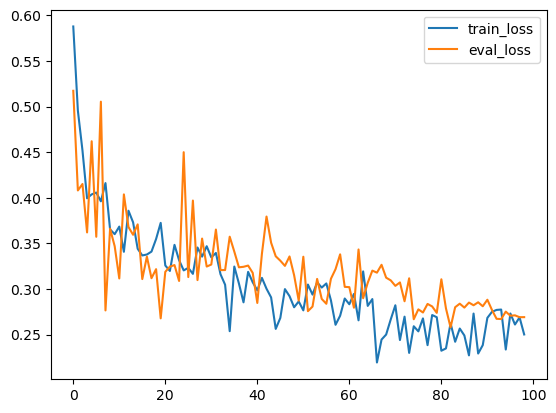

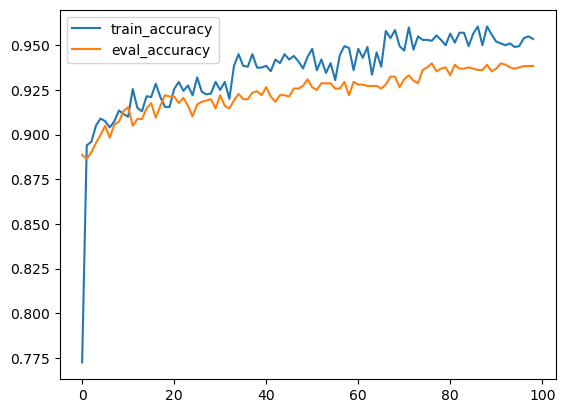

In [9]:
# Plot the results
import matplotlib.pyplot as plt

train_loss = []
train_accuracy = []
eval_loss = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log["loss"])
    if 'train_accuracy' in log:
        train_accuracy.append(log["train_accuracy"])
    elif 'eval_loss' in log:
        eval_loss.append(log["eval_loss"])
        eval_accuracy.append(log["eval_accuracy"])

plt.plot(train_loss, label="train_loss")
plt.plot(eval_loss, label="eval_loss")
plt.legend()
plt.show()

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(eval_accuracy, label="eval_accuracy")
plt.legend()
plt.show()

In [10]:
# Load the best model and test 

# Find the best model checkpoint
max_accuracy = 0
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        if log['eval_accuracy'] > max_accuracy:
            max_accuracy = log['eval_accuracy']
            best_checkpoint = log['step']

print(best_checkpoint)

best_model = RobertaForSequenceClassification.from_pretrained(f"./lora_results/checkpoint-{best_checkpoint}")

# Test the best model
trainer = Trainer(
    model=best_model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.evaluate()


38500


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
100%|██████████| 218/218 [00:11<00:00, 18.62it/s]


{'eval_loss': 0.357233464717865,
 'eval_accuracy': 0.9323394495412844,
 'eval_runtime': 11.7697,
 'eval_samples_per_second': 74.088,
 'eval_steps_per_second': 18.522}